# Earth2MIP Demo - Custom Datasets

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ddf._src.data.local.xrda import LocalDataSourceXArray

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [ ]:
model_name = "pangu_6" # "fcnv2_sm"  

We have Get channel names without saving the model

In [ ]:
from ddf._src.models.variables import EARTH2MIP_MODEL_VARIABLES

# channel_names = EARTH2MIP_MODEL_VARIABLES["fcnv2_sm"]
channel_names = EARTH2MIP_MODEL_VARIABLES[model_name]

First, we need to load the model and put it to some processor, either `cpu` or some `cuda:x` device.

**Warning**: CPU is very slow even for inference.
It's not recommended.

In [ ]:
model = f"e2mip://{model_name}"
device = "cuda:1"

We initialize a special `earth2mip.networks.Inference` datastructure which has a host of different features for making predictions.
The most important thing is initializing a model from their registry or a custom model. 
And of course the device

In [ ]:
time_loop  = get_model(
    model=model,
    device=device,
)

In [ ]:
channel_names = time_loop.in_channel_names
# channel_names

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [ ]:
# starting timestep
t0 = datetime.datetime(2018,7,30)
print(f"Start Time (t0): {t0}")

# number of forecast steps
num_steps = 4 * 12 # 6h intervals

print(f"Number of Steps: {num_steps}")

Start Time (t0): 2018-07-30 00:00:00
Number of Steps: 10


## Custom Datasets

### NETCDF Files

Our first example will have a custom `.netcdf` file where we already have the variables available.

In [ ]:
save_name = Path("reanalysis_20180715_20180830_ics_v2")
save_name_sl = Path("reanalysis-202108010000-sl.nc")
save_name_pl = Path("reanalysis-202108010000-pl.nc")
save_path = Path("/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/")

file_paths = [
    save_path.joinpath(save_name_sl),
    save_path.joinpath(save_name_pl),
]
file_paths

[PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/reanalysis-202108010000-sl.nc'),
 PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/events/test/reanalysis-202108010000-pl.nc')]

In [ ]:
ds = xr.open_mfdataset(file_paths, combine="by_coords", engine="netcdf4")
ds

<xarray.Dataset> Size: 714MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1, level: 13)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2021-08-01
  * level      (level) int32 52B 100 1000 200 300 400 50 ... 150 600 250 700 925
Data variables: (12/14)
    v10        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v100       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    msl        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    z          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    q          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    t          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    r          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    u          (time, level, latitude, longitude) float64 108MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-26 15:52:58 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

#### Parameters

We have some key parameters we need to set when dealing with this dataset.

**Name Convention**.
The name convention follows the *full name*, e.g., "10m_u_component_of_wind". This convention is set by the CDS.
We have a database within the library for all variables that are related to the AI models so it will recognize all names and do the translation even though we provided a list of `channel_names` which have the short form format.

**Pressure Name**.
We need to specify what is the pressure level name. 
This varies across datasets so the user can manually specify it to match theirs.

**Engine**.
We use the native `xarray.open_mfdataset(..., engine=...)` function.
So we are free to specify whichever engine that is our dataset format.
Even though this example uses `.netcdf`, we are also compatible with whichever formats are available.

In [ ]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    # name_convention="era5_name",
    name_convention="short_name",
    engine="netcdf4", 
    
)

In [ ]:
out_xr = data_source_xr[t0]

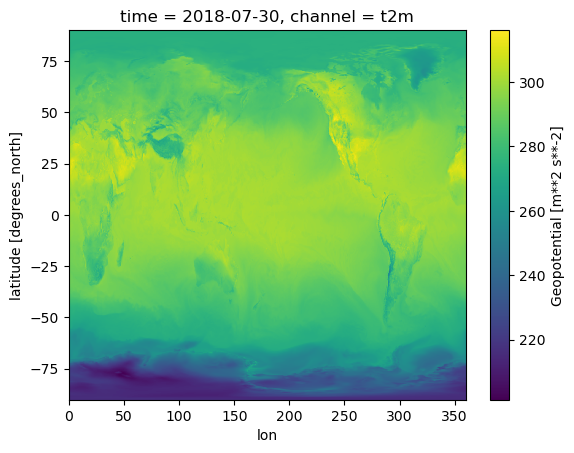

In [ ]:
out_xr.sel(channel="t2m").plot()

## Inference Loop

These are the same steps as the previous tutorial.

In [ ]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source_xr, 
    time=t0
)

/home/juanjohn/miniconda/envs/ddp/lib/python3.10/site-packages/torch/_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2024-06-26 19:05:56.371910370 [E:onnxruntime:, sequential_executor.cc:516 ExecuteKernel] Non-zero status code returned while running MatMul node. Name:'/b1/a12/MatMul' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Failed to allocate memory for requested buffer of size 1234206720



RuntimeError: Error in execution: Non-zero status code returned while running MatMul node. Name:'/b1/a12/MatMul' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:376 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool, onnxruntime::Stream*, bool, onnxruntime::WaitNotificationFn) Failed to allocate memory for requested buffer of size 1234206720


KeyError: "'channel' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'longitude': 1440, 'latitude': 721, 'time': 1, 'level': 13})"

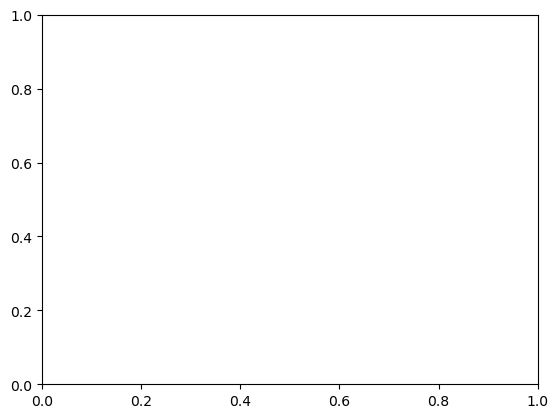

In [ ]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=-1).squeeze().plot.pcolormesh(ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.show()